In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')

In [3]:
from src.lib.fact_dataset_generator import FactDatasetGenerator
import numpy as np
import sys
import pandas as pd
import torch
import json

# Embeddings Experiment

## 1. Visualize hallucinations in training data space

## 2. Check if hallucinations are close to monofacts (closest training point)

## 3. Find Areas in the training data space with clustering

## 4. Check if hallucination rate is higher in the clusters with lots of monofacts

# Loading training data embeddings

In [59]:
loaded_monofact_embeddings = []
loaded_normal_fact_embeddings = []


with open("../src/experiment/monofact_embeddings.json","r") as f:
    for line in f:
        loaded_monofact_embeddings.append(json.loads(line))
with open("../src/experiment/normal_fact_embeddings.json","r") as f:
    for line in f:
        loaded_normal_fact_embeddings.append(json.loads(line))


In [60]:
monofact_embeddings = []
normal_fact_embeddings = []
all_training_embeddings = []
embedding_of = []

for loaded_normal_fact, loaded_normal_fact_embedding in loaded_normal_fact_embeddings:
    normal_fact_embeddings.append((loaded_normal_fact, torch.tensor(loaded_normal_fact_embedding)))
    all_training_embeddings.append(torch.tensor(loaded_normal_fact_embedding))
    embedding_of.append('Popular fact')
for loaded_monofact, loaded_monofact_embedding in loaded_monofact_embeddings:
    monofact_embeddings.append((loaded_monofact, torch.tensor(loaded_monofact_embedding)))
    all_training_embeddings.append(torch.tensor(loaded_monofact_embedding))
    embedding_of.append('Monofact')

In [61]:
all_training_embeddings_numpy = torch.cat([a.unsqueeze(0) for a in all_training_embeddings]).detach().numpy()

In [62]:
torch.cuda.empty_cache()

In [63]:
all_training_embeddings_numpy.shape

(800, 1536)

# Load embeddings of generations

In [64]:
generated_hallucinations_embeddings = []
with open("../src/experiment/hallucination_embeddings.json","r") as f:
    for line in f:
        generated_hallucinations_embeddings.append(json.loads(line))

generated_facts_embeddings = []
with open("../src/experiment/generated_fact_embeddings.json","r") as f:
    for line in f:
        generation = json.loads(line)
        is_hallucination = False

        # Filter out hallucinations
        for (hallucination, _) in generated_hallucinations_embeddings:
            if str(generation[0]) == str(hallucination):
                is_hallucination = True
                break

        if is_hallucination is False:
            generated_facts_embeddings.append(generation)

In [65]:
len(generated_facts_embeddings), len(generated_hallucinations_embeddings)

(945, 55)

# 1. Visualize training and hallucinations space

### add hallucinations to embeddings to visualize

In [66]:
hallucinations_embeddings_numpy = torch.cat([torch.Tensor(a[1]).unsqueeze(0) for a in generated_hallucinations_embeddings]).detach().numpy()

In [67]:
hallucinations_embeddings_numpy.shape

(55, 1536)

In [68]:
numpy_to_plot = np.concatenate([all_training_embeddings_numpy, hallucinations_embeddings_numpy])

import numpy as np
from sklearn.manifold import TSNE
# fit tsne on training samples
tsne = TSNE(n_components=2, learning_rate='auto',
                  init='random', perplexity=3)

X_embedded = tsne.fit_transform(numpy_to_plot)

In [69]:
embedding_of += (['Hallucination'] * len(generated_hallucinations_embeddings))

In [70]:
import matplotlib.pyplot as plt

In [71]:
colors = {
    'Hallucination': 'red',
    'Popular fact': 'lightblue',
    'Monofact': 'purple'
}

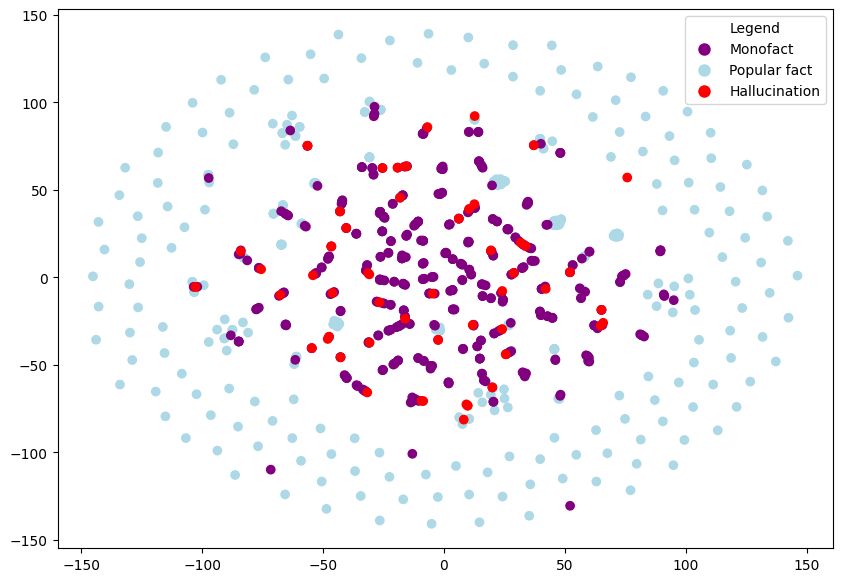

In [73]:
unique_labels = set(embedding_of)
label_color_map = {label: colors[label] for label in unique_labels}

# Create scatter plot
plt.figure(figsize=(10, 7))
plt.scatter(X_embedded[:, 0], X_embedded[:, 1], c=[colors[c] for c in embedding_of])

# Create a list of handles (proxy artists) for the legend
handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=color, markersize=10) for label, color in label_color_map.items()]
labels = list(label_color_map.keys())

# Add legend to the plot
plt.legend(handles, labels, title="Legend")

# Show the plot
plt.savefig('../assets/hallucination_in_space.png', dpi=500)
plt.show()

# 2. Check to which points hallucinations vs true generations are closest

In [74]:
from numpy import dot
import numpy as np
from numpy.linalg import norm

def dist(tensor_a, tensor_b):
    a = tensor_a.detach().numpy()
    b = tensor_b.detach().numpy()
    # return dot(a, b)/(norm(a)*norm(b))
    return np.linalg.norm(a-b)

In [75]:
def closest_different_point(embedding, top_k = 3):
    smallest_dist = 1E9
    result = None

    distances = []
    
    for loaded_monofact, loaded_monofact_embedding in loaded_monofact_embeddings:
        mf_embedding = torch.tensor(loaded_monofact_embedding)

        d = dist(embedding, mf_embedding)
        distances.append({'dist': d, 'type': 'Monofact'})

    for loaded_normal_fact, loaded_normal_fact_embedding in loaded_normal_fact_embeddings:
        nf_embedding = torch.tensor(loaded_normal_fact_embedding)

        d = dist(embedding, nf_embedding)
        distances.append({'dist': d, 'type': 'Popular Fact'})

    return pd.DataFrame(distances).sort_values(by='dist').reset_index(drop=True)['type'].head(top_k).value_counts()

In [81]:
from tqdm import tqdm

In [ ]:
result = []

for embedding in tqdm(generated_facts_embeddings):
    embedding = torch.Tensor(embedding[1])
    closest = dict(closest_different_point(embedding, top_k=3))

    closest_point = {'Monofact': 0, 'Hallucination': 0, 'Popular fact': 0}
    closest_point.update(**closest)

    closest_point['Point'] = 'Generated True Fact'

    print('Generated True Fact', closest)

    result.append(closest_point)

  0%|▏                                                                                                                   | 2/945 [00:00<02:41,  5.82it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Popular Fact': 3}


  0%|▍                                                                                                                   | 4/945 [00:00<02:35,  6.06it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Monofact': 3}


  1%|▋                                                                                                                   | 6/945 [00:01<02:32,  6.16it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Monofact': 3}


  1%|▉                                                                                                                   | 8/945 [00:01<02:33,  6.09it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Popular Fact': 3}


  1%|█▏                                                                                                                 | 10/945 [00:01<02:30,  6.23it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Popular Fact': 3}


  1%|█▍                                                                                                                 | 12/945 [00:02<02:41,  5.78it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Popular Fact': 3}


  1%|█▋                                                                                                                 | 14/945 [00:02<02:36,  5.93it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Popular Fact': 3}


  2%|█▉                                                                                                                 | 16/945 [00:02<02:39,  5.81it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Monofact': 3}


  2%|██▏                                                                                                                | 18/945 [00:03<02:36,  5.94it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Popular Fact': 3}


  2%|██▍                                                                                                                | 20/945 [00:03<02:37,  5.86it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Popular Fact': 3}


  2%|██▋                                                                                                                | 22/945 [00:03<02:29,  6.18it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


  3%|██▉                                                                                                                | 24/945 [00:04<02:29,  6.16it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


  3%|███                                                                                                                | 25/945 [00:04<02:32,  6.02it/s]

Generated True Fact {'Popular Fact': 2, 'Monofact': 1}


  3%|███▎                                                                                                               | 27/945 [00:04<02:40,  5.71it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Monofact': 3}


  3%|███▌                                                                                                               | 29/945 [00:04<02:33,  5.95it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Popular Fact': 3}


  3%|███▊                                                                                                               | 31/945 [00:05<02:33,  5.97it/s]

Generated True Fact {'Popular Fact': 2, 'Monofact': 1}
Generated True Fact {'Monofact': 3}


  3%|████                                                                                                               | 33/945 [00:05<02:37,  5.80it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Popular Fact': 2, 'Monofact': 1}


  4%|████▎                                                                                                              | 35/945 [00:05<02:28,  6.13it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Popular Fact': 3}


  4%|████▌                                                                                                              | 37/945 [00:06<02:33,  5.93it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Popular Fact': 2, 'Monofact': 1}


  4%|████▋                                                                                                              | 39/945 [00:06<02:32,  5.95it/s]

Generated True Fact {'Popular Fact': 2, 'Monofact': 1}
Generated True Fact {'Popular Fact': 3}


  4%|████▉                                                                                                              | 41/945 [00:06<02:26,  6.17it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


  5%|█████▏                                                                                                             | 43/945 [00:07<02:27,  6.13it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Popular Fact': 3}


  5%|█████▍                                                                                                             | 45/945 [00:07<02:23,  6.28it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Monofact': 3}


  5%|█████▋                                                                                                             | 47/945 [00:07<02:25,  6.15it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Popular Fact': 3}


  5%|█████▉                                                                                                             | 49/945 [00:08<02:23,  6.26it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Monofact': 3}


  5%|██████▏                                                                                                            | 51/945 [00:08<02:21,  6.31it/s]

Generated True Fact {'Popular Fact': 2, 'Monofact': 1}
Generated True Fact {'Popular Fact': 3}


  6%|██████▍                                                                                                            | 53/945 [00:08<02:21,  6.29it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


  6%|██████▋                                                                                                            | 55/945 [00:09<02:23,  6.20it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Popular Fact': 3}


  6%|██████▉                                                                                                            | 57/945 [00:09<02:22,  6.25it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Popular Fact': 3}


  6%|███████▏                                                                                                           | 59/945 [00:09<02:19,  6.33it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Popular Fact': 3}


  6%|███████▍                                                                                                           | 61/945 [00:10<02:19,  6.33it/s]

Generated True Fact {'Popular Fact': 2, 'Monofact': 1}
Generated True Fact {'Monofact': 3}


  7%|███████▋                                                                                                           | 63/945 [00:10<02:18,  6.38it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Popular Fact': 3}


  7%|███████▉                                                                                                           | 65/945 [00:10<02:22,  6.18it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


  7%|████████▏                                                                                                          | 67/945 [00:11<02:23,  6.13it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Monofact': 3}


  7%|████████▍                                                                                                          | 69/945 [00:11<02:26,  5.99it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


  8%|████████▋                                                                                                          | 71/945 [00:11<02:22,  6.13it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Popular Fact': 3}


  8%|████████▉                                                                                                          | 73/945 [00:12<02:20,  6.22it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


  8%|█████████▏                                                                                                         | 75/945 [00:12<02:19,  6.23it/s]

Generated True Fact {'Popular Fact': 2, 'Monofact': 1}
Generated True Fact {'Monofact': 3}


  8%|█████████▎                                                                                                         | 77/945 [00:12<02:20,  6.19it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


  8%|█████████▌                                                                                                         | 79/945 [00:13<02:22,  6.09it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


  9%|█████████▊                                                                                                         | 81/945 [00:13<02:17,  6.28it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


  9%|██████████                                                                                                         | 83/945 [00:13<02:19,  6.19it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


  9%|██████████▎                                                                                                        | 85/945 [00:13<02:20,  6.11it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Popular Fact': 3}


  9%|██████████▌                                                                                                        | 87/945 [00:14<02:20,  6.11it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


  9%|██████████▊                                                                                                        | 89/945 [00:14<02:19,  6.12it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Popular Fact': 3}


 10%|███████████                                                                                                        | 91/945 [00:14<02:18,  6.16it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Monofact': 3}


 10%|███████████▎                                                                                                       | 93/945 [00:15<02:19,  6.11it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Monofact': 3}


 10%|███████████▌                                                                                                       | 95/945 [00:15<02:20,  6.06it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Popular Fact': 3}


 10%|███████████▊                                                                                                       | 97/945 [00:15<02:19,  6.06it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


 10%|████████████                                                                                                       | 99/945 [00:16<02:16,  6.19it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


 11%|████████████▏                                                                                                     | 101/945 [00:16<02:18,  6.09it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


 11%|████████████▍                                                                                                     | 103/945 [00:16<02:27,  5.69it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


 11%|████████████▋                                                                                                     | 105/945 [00:17<02:20,  5.99it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Popular Fact': 3}


 11%|████████████▉                                                                                                     | 107/945 [00:17<02:16,  6.13it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Popular Fact': 3}


 12%|█████████████▏                                                                                                    | 109/945 [00:17<02:17,  6.10it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Popular Fact': 3}


 12%|█████████████▍                                                                                                    | 111/945 [00:18<02:18,  6.01it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


 12%|█████████████▋                                                                                                    | 113/945 [00:18<02:15,  6.15it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


 12%|█████████████▊                                                                                                    | 115/945 [00:18<02:12,  6.26it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Monofact': 3}


 12%|██████████████                                                                                                    | 117/945 [00:19<02:16,  6.08it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Popular Fact': 3}


 13%|██████████████▎                                                                                                   | 119/945 [00:19<02:16,  6.03it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


 13%|██████████████▍                                                                                                   | 120/945 [00:19<02:14,  6.12it/s]

Generated True Fact {'Monofact': 3}


 13%|██████████████▋                                                                                                   | 122/945 [00:20<02:36,  5.26it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Monofact': 3}


 13%|██████████████▉                                                                                                   | 124/945 [00:20<02:28,  5.51it/s]

Generated True Fact {'Popular Fact': 2, 'Monofact': 1}
Generated True Fact {'Popular Fact': 3}


 13%|███████████████▏                                                                                                  | 126/945 [00:20<02:27,  5.56it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Popular Fact': 3}


 14%|███████████████▍                                                                                                  | 128/945 [00:21<02:18,  5.90it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Monofact': 3}


 14%|███████████████▋                                                                                                  | 130/945 [00:21<02:15,  6.02it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


 14%|███████████████▉                                                                                                  | 132/945 [00:21<02:10,  6.25it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Popular Fact': 3}


 14%|████████████████▏                                                                                                 | 134/945 [00:22<02:11,  6.18it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


 14%|████████████████▍                                                                                                 | 136/945 [00:22<02:14,  6.03it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


 15%|████████████████▋                                                                                                 | 138/945 [00:22<02:14,  6.00it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Monofact': 2, 'Popular Fact': 1}


 15%|████████████████▉                                                                                                 | 140/945 [00:23<02:13,  6.03it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Monofact': 3}


 15%|█████████████████▏                                                                                                | 142/945 [00:23<02:12,  6.07it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


 15%|█████████████████▎                                                                                                | 144/945 [00:23<02:12,  6.03it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Popular Fact': 3}


 15%|█████████████████▌                                                                                                | 146/945 [00:24<02:13,  5.97it/s]

Generated True Fact {'Popular Fact': 2, 'Monofact': 1}
Generated True Fact {'Popular Fact': 3}


 16%|█████████████████▊                                                                                                | 148/945 [00:24<02:11,  6.05it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Popular Fact': 3}


 16%|██████████████████                                                                                                | 150/945 [00:24<02:09,  6.15it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Monofact': 3}


 16%|██████████████████▎                                                                                               | 152/945 [00:25<02:08,  6.15it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Popular Fact': 3}


 16%|██████████████████▌                                                                                               | 154/945 [00:25<02:09,  6.10it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Popular Fact': 3}


 17%|██████████████████▊                                                                                               | 156/945 [00:25<02:11,  6.01it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Monofact': 3}


 17%|███████████████████                                                                                               | 158/945 [00:26<02:06,  6.24it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Monofact': 3}


 17%|███████████████████▎                                                                                              | 160/945 [00:26<02:07,  6.17it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Popular Fact': 2, 'Monofact': 1}


 17%|███████████████████▌                                                                                              | 162/945 [00:26<02:05,  6.26it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Popular Fact': 3}


 17%|███████████████████▊                                                                                              | 164/945 [00:27<02:07,  6.14it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


 18%|████████████████████                                                                                              | 166/945 [00:27<02:05,  6.19it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


 18%|████████████████████▎                                                                                             | 168/945 [00:27<02:05,  6.17it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


 18%|████████████████████▌                                                                                             | 170/945 [00:28<02:09,  5.96it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Popular Fact': 3}


 18%|████████████████████▋                                                                                             | 172/945 [00:28<02:06,  6.10it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Popular Fact': 3}


 18%|████████████████████▉                                                                                             | 174/945 [00:28<02:04,  6.17it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


 19%|█████████████████████▏                                                                                            | 176/945 [00:29<02:09,  5.95it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Popular Fact': 3}


 19%|█████████████████████▍                                                                                            | 178/945 [00:29<02:03,  6.22it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Popular Fact': 3}


 19%|█████████████████████▋                                                                                            | 180/945 [00:29<02:01,  6.30it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


 19%|█████████████████████▉                                                                                            | 182/945 [00:30<02:02,  6.25it/s]

Generated True Fact {'Popular Fact': 3}
Generated True Fact {'Monofact': 3}


 19%|██████████████████████▏                                                                                           | 184/945 [00:30<02:02,  6.20it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Popular Fact': 3}


 20%|██████████████████████▍                                                                                           | 186/945 [00:30<02:00,  6.29it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


 20%|██████████████████████▋                                                                                           | 188/945 [00:31<02:03,  6.12it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


 20%|██████████████████████▉                                                                                           | 190/945 [00:31<02:08,  5.86it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


 20%|███████████████████████▏                                                                                          | 192/945 [00:31<02:04,  6.04it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Popular Fact': 3}


 21%|███████████████████████▍                                                                                          | 194/945 [00:32<02:04,  6.02it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


 21%|███████████████████████▋                                                                                          | 196/945 [00:32<02:02,  6.12it/s]

Generated True Fact {'Monofact': 3}
Generated True Fact {'Monofact': 3}


 21%|███████████████████████▊                                                                                          | 197/945 [00:32<02:02,  6.13it/s]

In [ ]:
closest_to_true_facts = pd.DataFrame(result).groupby(by='Point').sum() / len(generated_facts_embeddings)
closest_to_true_facts 

In [ ]:
result = []

for embedding in tqdm(generated_hallucination_embeddings):
    embedding = torch.Tensor(embedding[1])
    closest = dict(closest_different_point(embedding, top_k=3))

    closest_point = {'Monofact': 0, 'Hallucination': 0, 'Popular fact': 0}
    closest_point.update(**closest)

    closest_point['Point'] = 'Generated True Fact'

    print('Generated True Fact', closest)

    result.append(closest_point)

In [ ]:
closest_to_hallucinations = pd.DataFrame(result).groupby(by='Point').sum() / len(generated_hallucination_embeddings)
closest_to_hallucinations

# 3. Find Areas in the training space with clustering